In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")
df = df.dropna()

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
    "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
    "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
    "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
    "quantity_other", "quantity_MW"
]
target = "price_EUR_MWh"

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])


In [ ]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

class DSSM(nn.Module):
    """
    Deep Structured State Model (DSSM) for time series forecasting.
    This model uses a GRU for state representation and a feedforward network for observation modeling.
    """
    def __init__(self, input_dim, state_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True)
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)

In [ ]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, optimizer, and loss function
model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training the model
n_epochs = 30
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.4027, Val Loss: 0.1360
Epoch 2, Train Loss: 0.2660, Val Loss: 0.1248
Epoch 3, Train Loss: 0.2212, Val Loss: 0.1248
Epoch 4, Train Loss: 0.1878, Val Loss: 0.1159
Epoch 5, Train Loss: 0.1680, Val Loss: 0.1039
Epoch 6, Train Loss: 0.1524, Val Loss: 0.1063
Epoch 7, Train Loss: 0.1326, Val Loss: 0.0943
Epoch 8, Train Loss: 0.1228, Val Loss: 0.1053
Epoch 9, Train Loss: 0.1115, Val Loss: 0.0911
Epoch 10, Train Loss: 0.1030, Val Loss: 0.1032
Epoch 11, Train Loss: 0.0946, Val Loss: 0.0985
Epoch 12, Train Loss: 0.0913, Val Loss: 0.0908
Epoch 13, Train Loss: 0.0833, Val Loss: 0.0990
Epoch 14, Train Loss: 0.0782, Val Loss: 0.0892
Epoch 15, Train Loss: 0.0735, Val Loss: 0.0976
Epoch 16, Train Loss: 0.0708, Val Loss: 0.0979
Epoch 17, Train Loss: 0.0662, Val Loss: 0.1124
Epoch 18, Train Loss: 0.0645, Val Loss: 0.1057
Epoch 19, Train Loss: 0.0625, Val Loss: 0.1024
Epoch 20, Train Loss: 0.0570, Val Loss: 0.0967
Epoch 21, Train Loss: 0.0568, Val Loss: 0.1058
Epoch 22, Train Loss: 

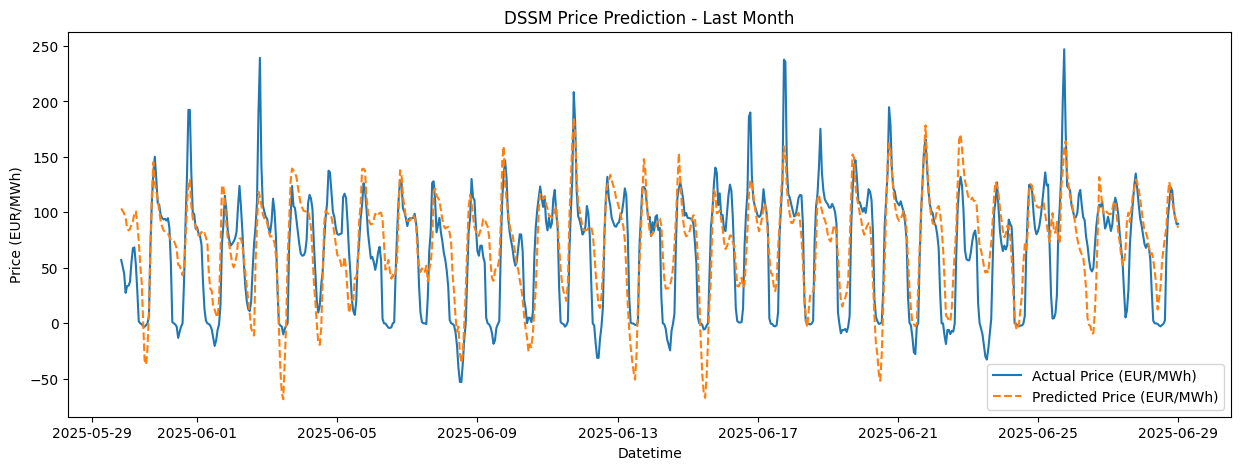

In [ ]:
# Evaluation on the last month
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        preds = model(x)
        all_preds.append(preds.numpy())
        all_actuals.append(t.squeeze(-1).numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

/var/folders/vg/2mjpcbv55m966znhbf9c5k580000gn/T/ipykernel_92123/1776833278.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=24, freq="H")


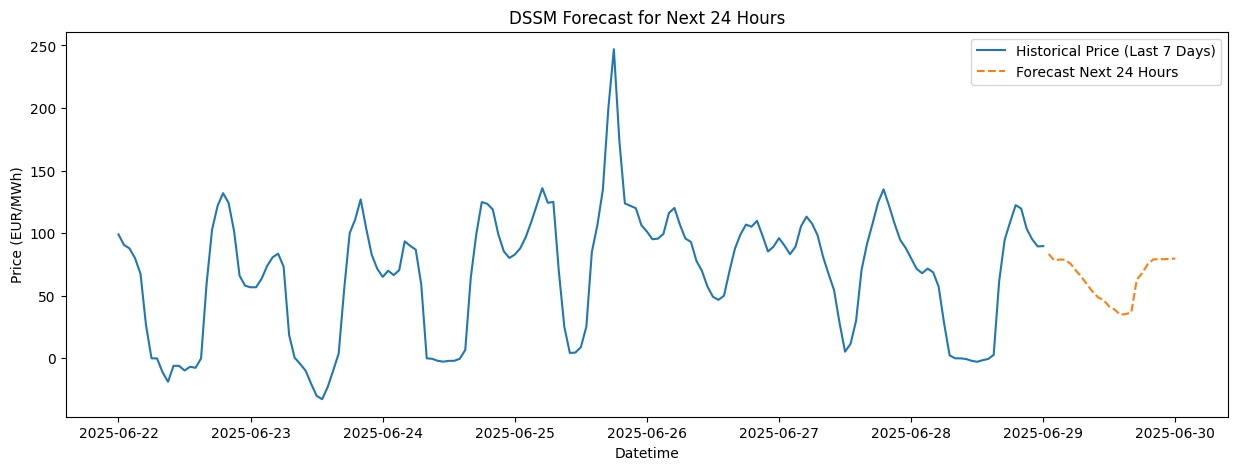

In [ ]:
# Forecasting for the next 24 hours
sequence_length = 24

latest_features = df[features].iloc[-sequence_length:]
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0) # Converting to tensor

model.eval()
forecast = []
current_seq = input_seq.clone()

with torch.no_grad():
    for _ in range(sequence_length):
        pred = model(current_seq).item()
        forecast.append(pred)

        # Shifting sequence and append new prediction as placeholder for next hour

        # Shift sequence left, drop first time step
        shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
        next_features = latest_scaled[-1]  # Using last known features as placeholder

        # Append to shifted sequence
        new_seq = np.vstack([shifted_seq, next_features])

        current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

# Inverse transform the forecasted values
forecast_inverse = scaler_y.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# Generate forecast datetimes
last_datetime = df["datetime"].iloc[-1]
forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=24, freq="H")

# Plotting the forecast for the next 24 hours
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_inverse, label="Forecast Next 24 Hours", linestyle="--")
plt.title("DSSM Forecast for Next 24 Hours")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()
